# Library Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib, pylab as plt
import numpy as np
from ast import literal_eval
import statsmodels.api as sm
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D

# Data import
Firstly, import the csv. 'literal_eval' is used to read the 'site_dict' and 'trader_dict' (which contain information for each site and trader) as lists instead of strings.

'site_dict' is a list of each site per run. It contains lists with two items per list, the site number and another list containing 5 items, a boolean (which is True if the site is a production site and False if it's not), the volume of product A, volume of product B, volume of product C, volume of product D.

'trader_dict' is a list of each trader per run. It contains a list with two items per list, the trader number and another list containing 3 items, the site number the trader is located on, its closeness centrality and its betweenness centrality.

Both 'dicts' are not actual Python dictionaries yet, but lists. They are converted to dicts when needed. Both 'dicts' are not displayed here, because it messes up the row sizes.

In [2]:
#literal_eval is used to parse the site_dict which the data of all traders on every site
def literal_converter(val):
    return val if val == 'avg_degree stuck' else literal_eval(val)

#The data from the different batches are merged into one dataframe
df = pd.read_csv('batch6_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter})
df = df.append(pd.read_csv('batch2_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter}))
df = df.append(pd.read_csv('batch2_remaining_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter}))
df = df.append(pd.read_csv('batch3_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter}))
df = df.append(pd.read_csv('batch4_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter}))
df = df.append(pd.read_csv('batch5_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter}))
df = df.append(pd.read_csv('batch6_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter}))
df = df.append(pd.read_csv('batch7_outputParameterSweep.csv', delimiter = ';', converters={'site_dict': literal_converter}))

#Runs that got stuck during the setup are removed
df_dropped = df[df.site_dict == 'avg_degree stuck']
df = df[df.site_dict != 'avg_degree stuck']

print("Number of runs stuck on average degree " + str(len(df_dropped)))



df.drop(['site_dict'], axis=1).head(10)

Number of runs stuck on average degree 171


,random_seed,ticks,equal_traders_production_site,traders_distribution,network_structure,proportion_inter_site_links,proportion_intra_site_links,proportion_mutual_neighbors,traders_production_site,one_production_site_dominance,...,local_knowledge,maximum_demand,circle_link_counter,inter_link_counter,intra_link_counter,mutual_link_counter,connect_components_link_counter,average_degree,clustering_coefficient,average_path_length
0,1,5000,False,uniform,hypothesis,0.0,0.001,2,0,10,...,0.1,1,100,0,1052,1107,19,4.556,0.610343,90.26507
1,1,5000,False,uniform,hypothesis,0.0,0.001,2,0,0,...,0.1,1,100,0,1083,1070,10,4.526,0.622357,97.69987
2,1,5000,False,uniform,hypothesis,0.0,0.001,2,0,0,...,0.5,1,100,0,1083,1070,10,4.526,0.622357,97.69987
3,1,5000,False,uniform,hypothesis,0.0,0.001,2,0,0,...,1.0,1,100,0,1083,1070,10,4.526,0.622357,97.69987
4,1,5000,False,uniform,hypothesis,0.0,0.001,2,0,30,...,0.5,1,100,0,1065,1090,7,4.524,0.619397,71.27465
5,1,5000,False,uniform,hypothesis,0.0,0.001,2,0,10,...,0.5,1,100,0,1052,1107,19,4.556,0.610343,90.26507
6,1,5000,False,uniform,hypothesis,0.0,0.001,2,0,10,...,1.0,1,100,0,1052,1107,19,4.556,0.610343,90.26507
7,1,5000,False,uniform,hypothesis,0.0,0.001,2,0,30,...,0.1,1,100,0,1065,1090,7,4.524,0.619397,71.27465
8,1,5000,False,uniform,hypothesis,0.0,0.001,2,0,50,...,1.0,1,100,0,1075,1077,8,4.520,0.618552,69.61648
9,1,5000,False,uniform,hypothesis,0.0,0.001,2,0,30,...,1.0,1,100,0,1065,1090,7,4.524,0.619397,71.27465


In [3]:
#Variables with string and boolean data are converted to integers
df['equal_traders_production_site'] *= 1
df = df.replace({'traders_distribution': {'uniform': 0, 'exponential': 1}, 'network_structure': {'random': 0, 'hypothesis': 1}})

### Calculate distribution widths for all runs

In [4]:
def calc_widths(row):
    widths = [0,0,0,0]
    site_dict = dict(row['site_dict'])
    for site_num, volume_list in site_dict.items():
        if volume_list[1] > 0:
            widths[0] += 1
        if volume_list[2] > 0:
            widths[1] += 1
        if volume_list[3] > 0:
            widths[2] += 1
        if volume_list[4] > 0:
            widths[3] += 1
    widths.sort()
    widths.reverse()
    return widths [0], widths[1], widths[2], widths[3]

df['volume_1'], df['volume_2'], df['volume_3'], df['volume_4'] = zip(*df.apply(calc_widths, axis=1))

### Calculate range 1 and range 2 for all runs

In [5]:
df["range_1"] = df.apply(lambda x: x["volume_1"] - x["volume_4"], axis = 1)
df["range_2"] = df.apply(lambda x: x["volume_1"] - x["volume_2"], axis = 1)

# Calculate Ddiff

### Calculate R1a & R2a

Tableware data taken from ICRATES data. 

Period definitions:

P1 = 25-1 BC

P2 = 1-25 AD

P3 = 25-50 AD

P4 = 50-75 AD

P5 = 75-100 AD

P6 = 100-125 AD

P7 = 125-150 AD

In [6]:
#Define all period width tables, sorted from highest to lowest (from ICRATES data)
P1 = [91.8, 22.0, 17.6, 8.2]
P2 = [85.8, 30.9, 18.5, 15.4]
P3 = [72.0, 29.6, 26.4, 24.0]
P4 = [64.0, 37.3, 35.3, 22.0]
P5 = [60.0, 41.5, 40.7, 20.0]
P6 = [45.9, 44.3, 42.6, 28.7]
P7 = [49.1, 34.3, 33.3, 31.5]

chosen_period = P1

#Calculate R1a and R2a
R1a = max(chosen_period) - min(chosen_period)
print('R1a = ' + str(R1a))

R2a = max(chosen_period) - chosen_period[1]
print('R2a = ' + str(R2a))

R1a = 83.6
R2a = 69.8


# Regression analysis

In [11]:
#Caculate the "Ddiff" for each run
import math
df["Ddiff"] = df.apply(lambda x: (math.sqrt((R1a - x["range_1"])**2) * ((R2a - x["range_2"])**2))*0.0001 , axis = 1)

The little bit of magic here is just to get the numbers into values that can be looked at. I have taken a square root, since we've squared everything and I also divided by 1000 to make the numbers reasonable. None of this changes anything in terms of the results, it's just easier to compare -0.12 to 0.34 than 1.2e8 etc). We still have the problem that both links variables are expressed in 0.000x numbers while the rest is 10-100. We'll deal with it below.

# Data visualisation

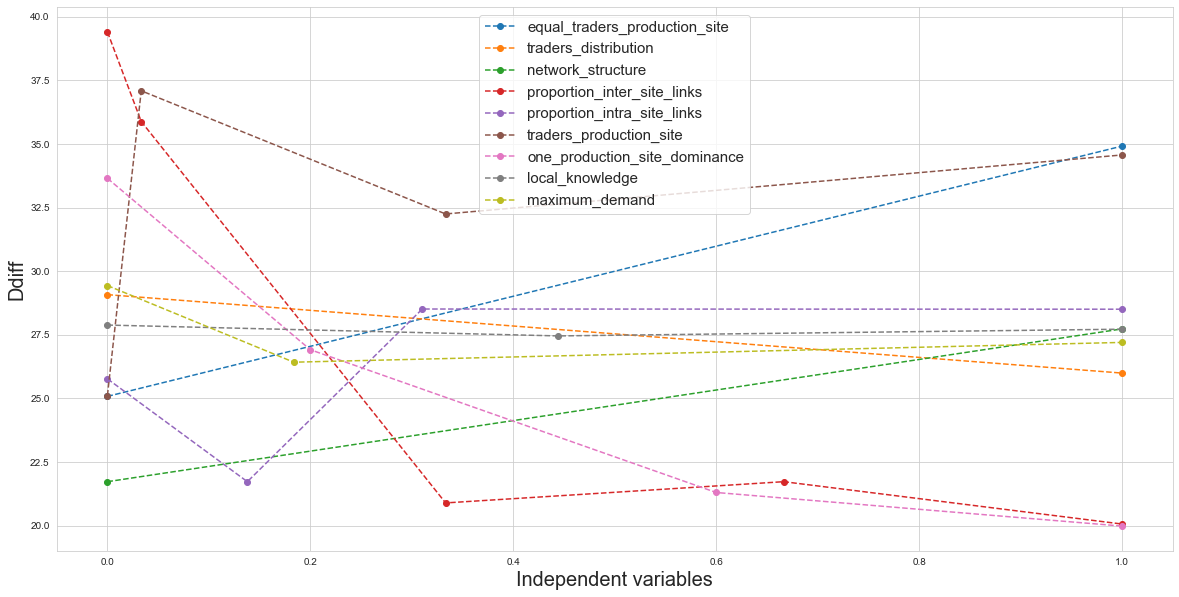

In [12]:
independent_variables = ['equal_traders_production_site',
                        'traders_distribution',
                        'network_structure',
                        'proportion_inter_site_links',
                        'proportion_intra_site_links',
                        'traders_production_site',
                        'one_production_site_dominance',
                        'local_knowledge',
                        'maximum_demand']

fig = plt.figure(figsize = (20, 10))
sns.set_style('whitegrid')

scaler=preprocessing.MinMaxScaler(feature_range=(0,1))

for i in independent_variables:
    df_temp = df.groupby(['{}'.format(i)]).mean().reset_index()
    df_temp["{}".format(i)]=scaler.fit_transform(df_temp[["{}".format(i)]])
    
    plt.plot(i, 'Ddiff', data=df_temp, linestyle='--', marker='o', label='{}'.format(i))
    

plt.xlabel('Independent variables', fontsize=20)
plt.ylabel('Ddiff', fontsize=20)
plt.legend(loc='best', fontsize=15)

### Regression on a full model

In [13]:
#Multiple regression of Ddiff? and all non-caterogiral/boolean independent variables + random_seed
X = df[['random_seed', 'proportion_inter_site_links', 'proportion_intra_site_links', 'traders_production_site', 'one_production_site_dominance', 'local_knowledge', 'maximum_demand']]
X = sm.add_constant(X)
mreg = sm.OLS(df['Ddiff_run'], X)
results = mreg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Ddiff_run   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     1628.
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:53:35   Log-Likelihood:                -45516.
No. Observations:               12159   AIC:                         9.105e+04
Df Residuals:                   12151   BIC:                         9.111e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

H:\WindowsSoftware\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### The bulk of predictive power of the model are: 'proportion_inter_site_links' and 'one_production_site_dominance' - pretty much 45%

In [14]:
#Multiple regression of range_1 and proportion_inter_site_links & one_production_site_dominance
X = df[['proportion_inter_site_links','one_production_site_dominance' ]]
X = sm.add_constant(X)
mreg = sm.OLS(df['Ddiff_run'], X)
results = mreg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Ddiff_run   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     4864.
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:53:39   Log-Likelihood:                -45964.
No. Observations:               12159   AIC:                         9.193e+04
Df Residuals:                   12156   BIC:                         9.196e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Equalise the coefficient
The values of coefficient between proportion_inter_site_links and one_production_site_dominance are very different because the former is 0.0001 - 0.003 whilse the latter is 0 - 50 so if we multiply the former by 1000 we'll be getting the same kind of values. 



In [15]:
#Multiple regression of range_1 and proportion_inter_site_links & one_production_site_dominance
df['prop_inter_site_links2'] = df['proportion_inter_site_links']*10000
X = df[['prop_inter_site_links2','one_production_site_dominance' ]]
X = sm.add_constant(X)
mreg = sm.OLS(df['Ddiff_run'], X)
results = mreg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Ddiff_run   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     4864.
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:53:42   Log-Likelihood:                -45964.
No. Observations:               12159   AIC:                         9.193e+04
Df Residuals:                   12156   BIC:                         9.196e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### The remaining variables explain only 4% of the ddiff

In [16]:
X = df[['maximum_demand','traders_production_site', 'proportion_intra_site_links' ]]
X = sm.add_constant(X)
mreg = sm.OLS(df['Ddiff_run'], X)
results = mreg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Ddiff_run   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     180.3
Date:                Mon, 18 Nov 2019   Prob (F-statistic):          2.21e-114
Time:                        18:53:44   Log-Likelihood:                -49274.
No. Observations:               12159   AIC:                         9.856e+04
Df Residuals:                   12155   BIC:                         9.859e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

### Individually it works as well. More or less

In [17]:
X = df['proportion_inter_site_links']
X = sm.add_constant(X)
reg = sm.OLS(df['Ddiff_run'], X)
results = reg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Ddiff_run   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     3771.
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:53:45   Log-Likelihood:                -47896.
No. Observations:               12159   AIC:                         9.580e+04
Df Residuals:                   12157   BIC:                         9.581e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [18]:
X = df['one_production_site_dominance']
X = sm.add_constant(X)
reg = sm.OLS(df['Ddiff_run'], X)
results = reg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Ddiff_run   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     2161.
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:53:46   Log-Likelihood:                -48544.
No. Observations:               12159   AIC:                         9.709e+04
Df Residuals:                   12157   BIC:                         9.711e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Random seed is insignificant

In [19]:
X = df['random_seed']
X = sm.add_constant(X)
reg = sm.OLS(df['Ddiff_run'], X)
results = reg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Ddiff_run   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.198
Date:                Mon, 18 Nov 2019   Prob (F-statistic):              0.274
Time:                        18:53:48   Log-Likelihood:                -49538.
No. Observations:               12159   AIC:                         9.908e+04
Df Residuals:                   12157   BIC:                         9.909e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          27.9601      0.279    100.226      

## Range 1

In [ ]:
for i in chosen_variable_names:
    fig, axes = plt.subplots(figsize = (20, 10))
    axes.set_ylim([0,100])
    ax = sns.violinplot(x=i, y = 'range_1', data=df)
    
    

## Range 2

In [ ]:
for i in chosen_variable_names:
    fig, axes = plt.subplots(figsize = (20, 10))
    axes.set_ylim([0,50])
    ax = sns.violinplot(x=i, y = 'range_2', data=df)

## Max closeness vs absence/presence max product

In [ ]:
data_X = []

max_closeness_Y = []
max_betweenness_Y = []

for row, index in df.iterrows():
    
    widths = {'A': 0,
              'B': 0,
              'C': 0,
              'D': 0
             }
    
    site_dict = dict(index['site_dict'])
    
    for site_num, site_data in site_dict.items():
        if site_data[1] > 0:
            widths['A'] += 1
        if site_data[2] > 0:
            widths['B'] += 1
        if site_data[3] > 0:
            widths['C'] += 1
        if site_data[4] > 0:
            widths['D'] += 1
            
    ware_1 = max(widths, key=widths.get)
    
    for site_num, site_data in site_dict.items():
        closeness_list = []
        betweenness_list = []
        
        for i in site_data[5]:
            closeness_list.append(i[0])
            betweenness_list.append(i[1])
        
        if ware_1 == 'A' and site_data[1] > 0:
            data_X.append(1)
            max_closeness_Y.append(max(closeness_list))
            max_betweenness_Y.append(max(betweenness_list))
        elif ware_1 == 'B' and site_data[2] > 0:
            data_X.append(1)
            max_closeness_Y.append(max(closeness_list))
            max_betweenness_Y.append(max(betweenness_list))
        elif ware_1 == 'C' and site_data[3] > 0:
            data_X.append(1)
            max_closeness_Y.append(max(closeness_list))
            max_betweenness_Y.append(max(betweenness_list))
        elif ware_1 == 'D' and site_data[4] > 0:
            data_X.append(1)
            max_closeness_Y.append(max(closeness_list))
            max_betweenness_Y.append(max(betweenness_list))
        else:
            data_X.append(0)
            max_closeness_Y.append(max(closeness_list))
            max_betweenness_Y.append(max(betweenness_list))

                
fig, axes = plt.subplots(figsize = (20, 10))
ax = sns.violinplot(x = data_X, y = max_closeness_Y) 
plt.xlabel('Absence (0) or presence (1) of the most widely distributed product per site', fontsize=20)
plt.ylabel('max_closeness per site', fontsize=20)

## Max betweenness vs absence/presence max product

In [ ]:
fig, axes = plt.subplots(figsize = (20, 10))
ax = sns.violinplot(x = data_X, y = max_betweenness_Y) 
plt.xlabel('Absence (0) or presence (1) of the most widely distributed product per site', fontsize=20)
plt.ylabel('max_betweenness per site', fontsize=20)

## Max closeness per production center vs width of that type

In [ ]:
data_X = []
data_Y_closeness = []
data_Y_betweenness = []

for row, index in df.iterrows():
    widths = {'A': 0,
              'B': 0,
              'C': 0,
              'D': 0
             }
    site_dict = dict(index['site_dict'])
    
    for site_num, site_data in site_dict.items():
        if site_data[1] > 0:
            widths['A'] += 1
        if site_data[2] > 0:
            widths['B'] += 1
        if site_data[3] > 0:
            widths['C'] += 1
        if site_data[4] > 0:
            widths['D'] += 1
    
    widths = sorted(widths.items(), key=lambda x:x[1], reverse=True)
    width_num = 1    
    for i in widths:
        for site_num, site_data in site_dict.items():
            if site_data[0] == i[0]:
                closeness_list = []
                betweenness_list = []
                
                for cb in site_data[5]:
                    closeness_list.append(cb[0])
                    betweenness_list.append(cb[1])
                
                data_Y_closeness.append(max(closeness_list))
                data_Y_betweenness.append(max(betweenness_list))
                data_X.append(i[1])
                
                
fig, axes = plt.subplots(figsize = (20, 10))
ax = plt.scatter(data_X, data_Y_betweenness) 
plt.xlabel('Distribution width of ware', fontsize=20)
plt.ylabel('max_betweenness of production site', fontsize=20)
                

In [ ]:
                
fig, axes = plt.subplots(figsize = (20, 10))
ax = plt.scatter(data_X, data_Y_closeness) 
plt.xlabel('Distribution width of ware', fontsize=20)
plt.ylabel('max_closeness of production site', fontsize=20)

## proportion_inter_site_links violin plots split by values

In [ ]:
fig, axes = plt.subplots(figsize = (20, 10))
axes.set_ylim([0,20])
ax = sns.violinplot(x='proportion_inter_site_links', y = 'range_1', data=df.loc[df['proportion_inter_site_links'] <= 0.0001])

In [ ]:
fig, axes = plt.subplots(figsize = (20, 10))
axes.set_ylim([0,100])
ax = sns.violinplot(x='proportion_inter_site_links', y = 'range_1', data=df.loc[df['proportion_inter_site_links'] > 0.0001])

In [ ]:
fig, axes = plt.subplots(figsize = (20, 10))
axes.set_ylim([0,20])
ax = sns.violinplot(x='proportion_inter_site_links', y = 'range_2', data=df.loc[df['proportion_inter_site_links'] <= 0.0001])

In [ ]:
fig, axes = plt.subplots(figsize = (20, 10))
axes.set_ylim([0,100])
ax = sns.violinplot(x='proportion_inter_site_links', y = 'range_2', data=df.loc[df['proportion_inter_site_links'] > 0.0001])

## Line graphs of significant variables

In [ ]:
fig = plt.figure(figsize = (15, 8))
sns.set_style("whitegrid")


df['one_production_site_dominance2'] = df['one_production_site_dominance']
df_grp_inter = df.groupby(['proportion_inter_site_links']).mean()
df_grp_dom = df.groupby(['one_production_site_dominance2']).mean()

plt.plot('prop_inter_site_links2', 'Ddiff_run',  data=df_grp_inter, linestyle='--', marker='o', label='proportion_inter_site_links')
plt.plot('one_production_site_dominance', 'Ddiff_run',  data=df_grp_dom, linestyle='--', marker='o', label='one_production_site_dominance')

plt.xlabel('Significant variables', fontsize=20)
plt.ylabel('Ddiff', fontsize=20)
plt.legend(loc='best', fontsize=15)

## Reg plot

In [ ]:
y = 'proportion_inter_site_links'

g = sns.jointplot(y=y, x='Ddiff_run', data=df, kind="hex", height=8)
g.set_axis_labels('Ddiff_run', y, fontsize=20)
#g.ax_joint.set_xscale('log')

In [ ]:
y = 'proportion_inter_site_links'

plt.figure(figsize=(15, 8))
plt.rcParams["axes.labelsize"] = 20

g = sns.regplot(y=y, x='Ddiff_run', data=df, line_kws = {'color':'red'})
#g.set_xscale('log')

# TESTS

In [ ]:
#Group the dataframe by each value of the independent variables (ie every experiment) and give them an experiment number
df['experiment_number']=df.groupby(['equal_traders_production_site', 'traders_distribution', 'network_structure', 'proportion_inter_site_links', 'proportion_intra_site_links', 'traders_production_site', 'one_production_site_dominance', 'local_knowledge', 'maximum_demand']).ngroup().add(1)
df.drop(['volume_1', 'volume_2', 'volume_3', 'volume_4', 'site_dict', 'circle_link_counter', 'inter_link_counter', 'intra_link_counter', 'mutual_link_counter', 'connect_components_link_counter', 'average_degree', 'clustering_coefficient', 'average_path_length', 'range_1', 'range_2'], axis=1).sort_values(by=['experiment_number', 'random_seed']).head(30)


In [ ]:
pairplots = sns.pairplot(data=df, height=5, kind='reg', plot_kws={'line_kws':{'color':'red'}}, y_vars=['proportion_inter_site_links'], x_vars=['Ddiff_run'])

In [ ]:
#New dataframe, group by experiment number and take the mean (for pairplots?)
df_experiment = df.groupby('experiment_number').mean()

In [ ]:
pairplots = sns.pairplot(data=df, height=10, kind='scatter', hue='traders_production_site', palette="hls", y_vars=['proportion_inter_site_links'], x_vars=['Ddiff_run'])

In [ ]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

xs = df_experiment['proportion_inter_site_links']
ys = df_experiment['proportion_intra_site_links']
zs = df_experiment['Ddiff_run']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

ax.set_xlabel('proportion_inter_site_links')
ax.set_ylabel('proportion_intra_site_links')
ax.set_zlabel('Ddiff_run')

plt.show()

In [ ]:
plt.scatter(x = df_experiment['proportion_inter_site_links'], 
            y = df_experiment['Ddiff_run'], 
            s = df_experiment['proportion_intra_site_links']*25000,
            alpha=0.4, 
            edgecolors='w')



plt.xlabel('proportion_inter_site_links')
plt.ylabel('proportion_intra_site_links')
plt.title('Ddiff_run', y=1.05)